## Aim: Understand distribution of samples in training set (and subsequently in neighbourhoods of latent space)


In [19]:
# Add path
import os
import sys
project_root = os.path.dirname(os.path.abspath(''))
sys.path.insert(0, project_root)
sys.path.insert(0, os.path.join(project_root, 'model'))
sys.path.insert(0, os.path.join(project_root, 'dataset_generation'))

# Reload modules
from importlib import reload
import util
import model
import value_decoder
import decoder
import encoder
import data_util
reload(util)
reload(model)
reload(value_decoder)
reload(decoder)
reload(encoder)
reload(data_util)

<module 'data_util' from '/Users/luis/Desktop/Cranmer2024/Workplace/smallMutations/similar-expressions/src/model/data_util.py'>

In [20]:
import torch
import numpy as np
import sympy as sp
import pandas as pd
from data_util import load_wandb_model, create_dataloader_from_wandb, data_from_loader
from debug_util import plot_var_distributions, plot_latent_distribution
from matplotlib import pyplot as plt
from typing import Union, List, Dict
from tqdm import tqdm
torch.manual_seed(42)
torch.set_grad_enabled(False)

# Load model and dataset
model, cfg = load_wandb_model(run='om4vbk2m', name='last.ckpt', project='simexp-03', replace=True, fallback_cfg_path='../model/config.yaml') # NB: This model is pre-normalisation introduction so local fallback config is used for these values.
train_loader, test_loader, info = create_dataloader_from_wandb(cfg)
val_x, syntax_cats, value_transform = info['val_x'], info['syntax_cats'], info['value_transform']

Imported model from run "om4vbk2m".
  | Name          | Type         | Params | Mode
------------------------------------------------------
0 | encoder       | Encoder      | 8.9 M  | eval
1 | decoder       | Decoder      | 6.6 M  | eval
2 | value_decoder | ValueDecoder | 6.4 M  | eval
------------------------------------------------------
21.9 M    Trainable params
0         Non-trainable params
21.9 M    Total params
87.677    Total estimated model params size (MB)
0         Modules in train mode
101       Modules in eval mode
Using dataset "dataset_241127_2" of size 1868052
DataLoader Summary
---------------------------------------------------------------------
  | Train        | Size: 1868052 | Batch: 512   | Batches: 3649 
  | valid        | Size: 207561  | Batch: 512   | Batches: 406  
---------------------------------------------------------------------


### 1. Check distribution of samples around a single sample (in y space)

- Take single sample from training set and compare the other samples to it (in y)
- Repeat for multiple samples to be more robust
- Using dataloaders from wandb run (easiest for now)

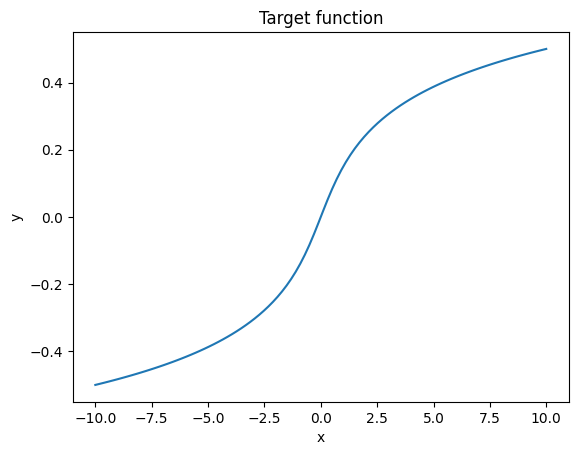

In [21]:
target_idx = 4
data_loader = train_loader  # FIXME: Only works with train_loader currently...
values_target = data_from_loader(data_loader, 'values', idx=target_idx)  

plt.plot(val_x.squeeze(), values_target.squeeze().detach().numpy())
plt.title('Target function')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [22]:
# Calculate MSE to target for all samples in training set

N = 2**21
BATCH_SIZE = 2**16
data_loader = train_loader

N = (min(len(data_loader.dataset), N) // BATCH_SIZE) * BATCH_SIZE  # Round down to nearest batch size
dist_y = torch.ones(N)
for i, values in tqdm(enumerate(data_from_loader(data_loader, 'values', batch_size=BATCH_SIZE, max_length=N)), total=N//BATCH_SIZE):
    assert values.isnan().sum() == 0, 'NaN values in dataset'
    dist_y[i*BATCH_SIZE:(i+1)*BATCH_SIZE] = torch.mean((values - values_target)**2, dim=1)  # MSE

mse_sorted = pd.Series(dist_y).sort_values()

100%|██████████| 28/28 [00:06<00:00,  4.41it/s]


In [23]:
(dist_y > 1).sum()


tensor(94862)

In [24]:
mse_sorted.index[-1]

np.int64(1094823)

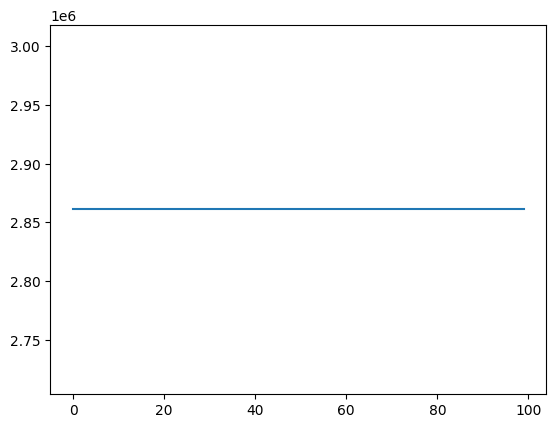

In [25]:
plt.plot(data_from_loader(data_loader, 'values', idx=mse_sorted.index[-1]).squeeze().detach().numpy())

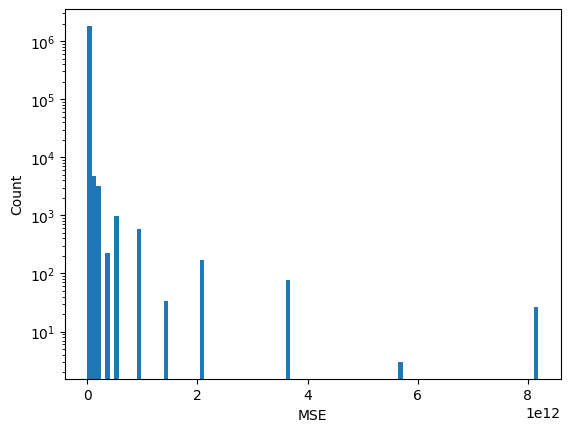

In [7]:
# Plot distribution of MSEs
plt.hist(dist_y.detach().numpy(), bins=100)
plt.xlabel('MSE')
plt.ylabel('Count')
plt.yscale('log')
plt.show()


In [14]:
# Plot sample with a specific MSE to target (to get an idea for meaning of magnitude of MSE)

import ipywidgets as widgets

mse_wanted = widgets.FloatLogSlider(
    value=3e-5,
    min=-7,
    max=12,
    step=0.1,
    description='MSE Target:',
    continuous_update=False
)

max_mse = widgets.FloatLogSlider(
    value=1e-3, 
    min=-7,
    max=12,
    step=0.1,
    description='Max MSE:',
    continuous_update=False
)

def update_plot(mse_target, mse_max):
    idx = (pd.Series(dist_y) - mse_target).abs().idxmin()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Left subplot - histogram
    counts, bins = np.histogram(dist_y.detach().numpy(), bins=100, range=(0, mse_max))
    ax1.bar(bins[:-1], counts, width=np.diff(bins), align='edge')
    ax1.axvline(x=mse_target, color='r', linestyle='--')
    ax1.set_yscale('log')
    ax1.set_xlabel('MSE')
    ax1.set_ylabel('Count')
    
    # Right subplot - function comparison
    ax2.plot(val_x.squeeze(), values_target.squeeze().detach().numpy(), label='Target', color='r')
    ax2.plot(val_x.squeeze(), data_from_loader(data_loader, 'values', idx=idx).squeeze().detach().numpy(), 
             label=f'MSE: {dist_y.detach().numpy()[idx]:.2e}')
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

widgets.interactive(update_plot, 
                   mse_target=mse_wanted,
                   mse_max=max_mse)

interactive(children=(FloatLogSlider(value=3e-05, continuous_update=False, description='MSE Target:', max=12.0…